In [58]:
import numpy as np
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [59]:
movies = pickle.load(open("../pickle/movies.pkl", "rb"))
cosine = pickle.load(open("../pickle/cosine_sim.pkl", "rb"))
knn_similarity = pickle.load(open("../pickle/knn.pkl", "rb"))
lsa = pickle.load(open("../pickle/lsa.pkl", "rb"))

In [60]:
# Cosine Similarity
def recommendMovieCosine(selected_movies):

    # Find the index of the movie that matches the title
    index = movies[movies["Series_Title"] == selected_movies].index[0]
    distance = sorted(list(enumerate(cosine[index])), reverse=True, key=lambda vector: vector[1])

    # Get the top 10 most similar movies
    recommended_movies_name = [movies.iloc[i[0]]["Series_Title"] 
    for i in distance[0:10]]

    return recommended_movies_name

In [61]:
# KNN
def recommendMovieKNN(selected_movies):

    index = movies[movies["Series_Title"] == selected_movies].index[0]
    
    # Reduce the dimensionality of the input movie (same transformation as training)
    pca = PCA(n_components=1000)  # Use the number of components you want
    similarity_reduced = pca.fit_transform(knn_similarity)  # Apply PCA to reduce dimensionality
    movie_reduced = pca.transform(knn_similarity[index].reshape(1, -1))
    
    # Perform the k-nearest neighbors search
    knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20)
    knn.fit(similarity_reduced)
    distances, indices = knn.kneighbors(movie_reduced, n_neighbors=10)
    indices = indices.flatten()  # Flatten the indices to use for Pandas indexing

    # Convert indices to integer for Pandas indexing
    recommended_movies_name = movies.iloc[indices]["Series_Title"].values[:k]

    return recommended_movies_name

In [62]:
# LSA
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

def find_similar_movies(target_vec, lsa):
    distances = []
    for idx, movie_vec in enumerate(lsa):
        diff = euclidean_distance(target_vec, movie_vec)
        distances.append((idx, diff))
    
    # Sort distances in ascending order
    distances.sort(key=lambda x: x[1])
    
    # Return similar movies
    return distances[:10]

def recommendMovieLSA(selected_movies):

    # Find the index of the movie that matches the title
    index = movies[movies["Series_Title"] == selected_movies].index[0]

    # Perform similarity search on the full dataset
    target_vec = lsa[index]
    similar_movies = find_similar_movies(target_vec, lsa)

    # Get the top 10 most similar movies
    recommended_movies_name = [movies.iloc[i[0]]["Series_Title"] 
    for i in similar_movies[0:10]]

    return recommended_movies_name

In [63]:
# Measure performance
# # Precision: measures how many of the top recommended items are relevant
def precision_at_k(same_series, y_true, y_pred, k):
    relevant = len(set(y_true) & set(y_pred[:k]))  # Intersection of ground truth and predicted
    if (relevant == same_series.shape[0]) & (same_series.shape[0] != 0):  
        return relevant / same_series.shape[0]
    return relevant / k

# Recall: measures how many relevant items are captured in the top recommendation
def recall_at_k(same_series, y_true, y_pred, k):
    relevant = len(set(y_true) & set(y_pred[:k]))
    if len(y_true) == 0: 
        return 0
    return relevant / len(y_true) 

# harmonic mean of precision and recall
def f1_at_k(prec, rec, y_true, y_pred, k):
    if prec + rec == 0:
        return 0
    return 2 * (prec * rec) / (prec + rec)

def chk_performance(selected_movies, similar_movies):
    same_series = movies[movies["Series_Title"].str.contains(selected_movies, case=False, na=False)]

    # movie must contain
    y_true = same_series["Series_Title"]

    # movies predicted
    y_pred = similar_movies

    k = 10

    precision = precision_at_k(same_series, y_true, y_pred, k)
    recall = recall_at_k(same_series, y_true, y_pred, k)
    f1 = f1_at_k(precision, recall, y_true, y_pred, k)

    return precision, recall, f1

In [64]:
all_movies = movies["Series_Title"].to_list()

In [65]:
# calculate the accuracy of cosine
cosine_precision = []
cosine_recall = []
cosine_f1 = []
for i in all_movies:
    movies_name = recommendMovieCosine(i)
    precision, recall, f1 = chk_performance(i, movies_name)
    cosine_precision.append(precision)
    cosine_recall.append(recall)
    cosine_f1.append(f1)

print(cosine_precision[0])
print(cosine_recall[0])
print(cosine_f1[0])
print(len(cosine_precision))
print(len(cosine_recall))
print(len(cosine_f1))

C:\Users\Asus\AppData\Local\Temp\ipykernel_25268\1370515065.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  same_series = movies[movies["Series_Title"].str.contains(selected_movies, case=False, na=False)]


1.0
1.0
1.0
1000
1000
1000


In [66]:
# calculate the accuracy of knn
knn_precision = []
knn_recall = []
knn_f1 = []
for i in all_movies:
    movies_name = recommendMovieCosine(i)
    precision, recall, f1 = chk_performance(i, movies_name)
    knn_precision.append(precision)
    knn_recall.append(recall)
    knn_f1.append(f1)

print(len(knn_precision))
print(len(knn_recall))
print(len(knn_f1))

C:\Users\Asus\AppData\Local\Temp\ipykernel_25268\1370515065.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  same_series = movies[movies["Series_Title"].str.contains(selected_movies, case=False, na=False)]


1000
1000
1000


In [67]:
# calculate the accuracy of lsa
lsa_precision = []
lsa_recall = []
lsa_f1 = []
for i in all_movies:
    movies_name = recommendMovieCosine(i)
    precision, recall, f1 = chk_performance(i, movies_name)
    lsa_precision.append(precision)
    lsa_recall.append(recall)
    lsa_f1.append(f1)

print(len(lsa_precision))
print(len(lsa_recall))
print(len(lsa_f1))

C:\Users\Asus\AppData\Local\Temp\ipykernel_25268\1370515065.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  same_series = movies[movies["Series_Title"].str.contains(selected_movies, case=False, na=False)]


1000
1000
1000


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Create a DataFrame to organize the data
data = pd.DataFrame({
    "Movies": all_movies,
    "Cosine Precision": cosine_precision,
    "Cosine Recall": cosine_recall,
    "Cosine F1": cosine_f1,
    "KNN Precision": knn_precision,
    "KNN Recall": knn_recall,
    "KNN F1": knn_f1,
    "LSA Precision": lsa_precision,
    "LSA Recall": lsa_recall,
    "LSA F1": lsa_f1
})

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Movies            1000 non-null   object 
 1   Cosine Precision  1000 non-null   float64
 2   Cosine Recall     1000 non-null   float64
 3   Cosine F1         1000 non-null   float64
 4   KNN Precision     1000 non-null   float64
 5   KNN Recall        1000 non-null   float64
 6   KNN F1            1000 non-null   float64
 7   LSA Precision     1000 non-null   float64
 8   LSA Recall        1000 non-null   float64
 9   LSA F1            1000 non-null   float64
dtypes: float64(9), object(1)
memory usage: 78.3+ KB


,Movies,Cosine Precision,Cosine Recall,Cosine F1,KNN Precision,KNN Recall,KNN F1,LSA Precision,LSA Recall,LSA F1
0,The Shawshank Redemption,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,The Godfather,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,The Dark Knight,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,The Godfather: Part II,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,12 Angry Men,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [70]:
# Assign diff table to precision, recall and f1
precision = data[["Movies", "Cosine Precision", "KNN Precision", "LSA Precision"]]
recall = data[["Movies", "Cosine Recall", "KNN Recall", "LSA Recall"]]
f1 = data[["Movies", "Cosine F1", "KNN F1", "LSA F1"]]

precision.head(3)

,Movies,Cosine Precision,KNN Precision,LSA Precision
0,The Shawshank Redemption,1.0,1.0,1.0
1,The Godfather,1.0,1.0,1.0
2,The Dark Knight,1.0,1.0,1.0


In [71]:
recall.head(3)

,Movies,Cosine Recall,KNN Recall,LSA Recall
0,The Shawshank Redemption,1.0,1.0,1.0
1,The Godfather,1.0,1.0,1.0
2,The Dark Knight,1.0,1.0,1.0


In [72]:
f1.head(3)

,Movies,Cosine F1,KNN F1,LSA F1
0,The Shawshank Redemption,1.0,1.0,1.0
1,The Godfather,1.0,1.0,1.0
2,The Dark Knight,1.0,1.0,1.0


In [73]:
# Melt the DataFrame to a long format suitable for plotting
precision_melted = precision.melt(id_vars="Movies", var_name="Algorithm", value_name="Precision")
precision_melted.head(3)

,Movies,Algorithm,Precision
0,The Shawshank Redemption,Cosine Precision,1.0
1,The Godfather,Cosine Precision,1.0
2,The Dark Knight,Cosine Precision,1.0


In [74]:
# Melt the DataFrame to a long format suitable for plotting
recall_melted = recall.melt(id_vars="Movies", var_name="Algorithm", value_name="Recall")
recall_melted.head(3)

,Movies,Algorithm,Recall
0,The Shawshank Redemption,Cosine Recall,1.0
1,The Godfather,Cosine Recall,1.0
2,The Dark Knight,Cosine Recall,1.0


In [75]:
# Melt the DataFrame to a long format suitable for plotting
f1_melted = f1.melt(id_vars="Movies", var_name="Algorithm", value_name="F1")
f1_melted.head(3)

,Movies,Algorithm,F1
0,The Shawshank Redemption,Cosine F1,1.0
1,The Godfather,Cosine F1,1.0
2,The Dark Knight,Cosine F1,1.0


c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


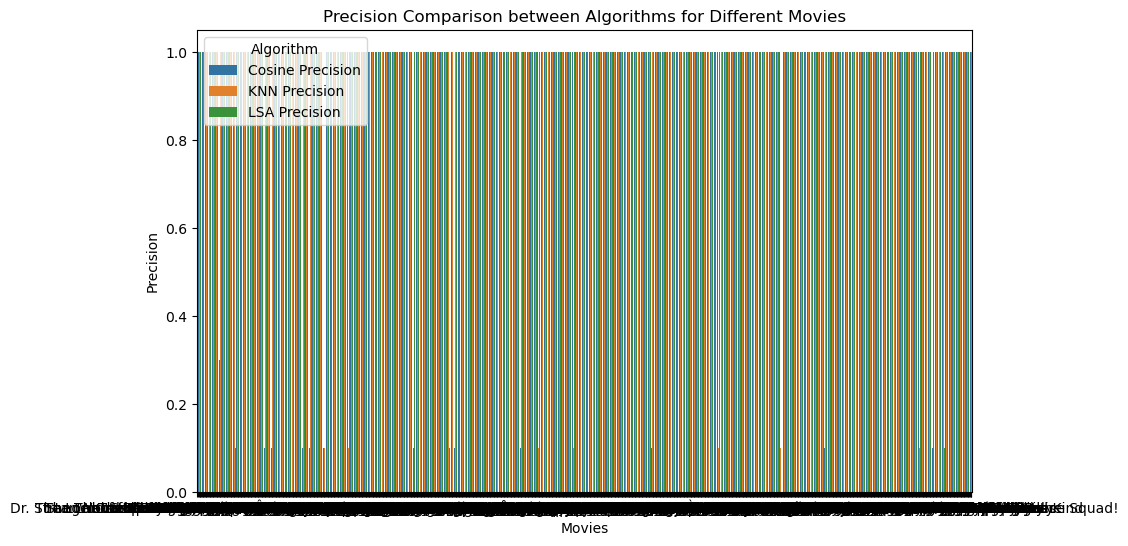

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="Precision", hue="Algorithm", data=precision_melted)

# Add title and labels
plt.title("Precision Comparison between Algorithms for Different Movies")
plt.ylabel("Precision")
plt.xlabel("Movies")

plt.show()

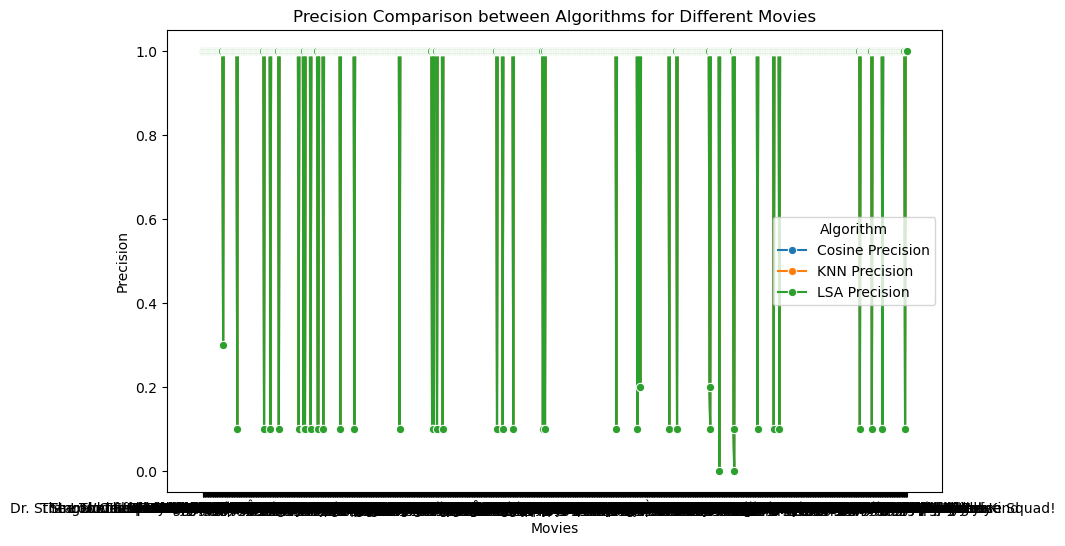

In [77]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="Precision", hue="Algorithm", data=precision_melted, marker="o")

# Add title and labels
plt.title("Precision Comparison between Algorithms for Different Movies")
plt.ylabel("Precision")
plt.xlabel("Movies")

plt.show()

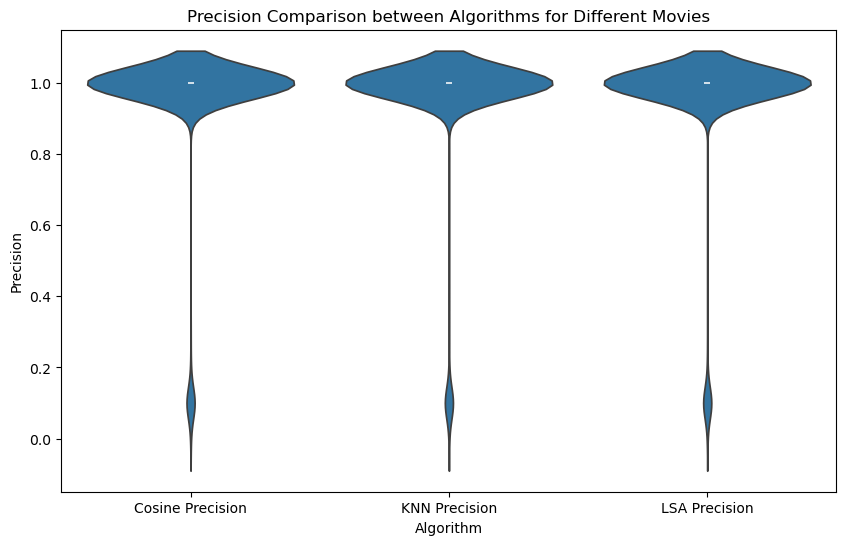

In [78]:
# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Algorithm', y='Precision', data=precision_melted)

plt.title('Precision Comparison between Algorithms for Different Movies')
plt.ylabel('Precision')
plt.xlabel('Algorithm')

plt.show()

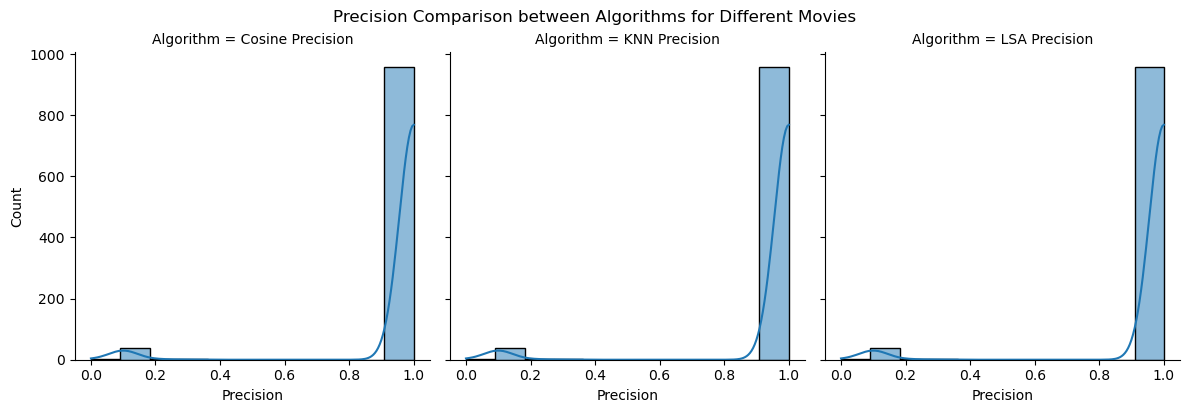

In [79]:
# FacetGrid of Histogram
g = sns.FacetGrid(precision_melted, col="Algorithm", height=4, aspect=1)
g.map(sns.histplot, "Precision", kde=True)

# Add title
plt.suptitle('Precision Comparison between Algorithms for Different Movies', y=1.02)

# Show the plot
plt.show()

c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


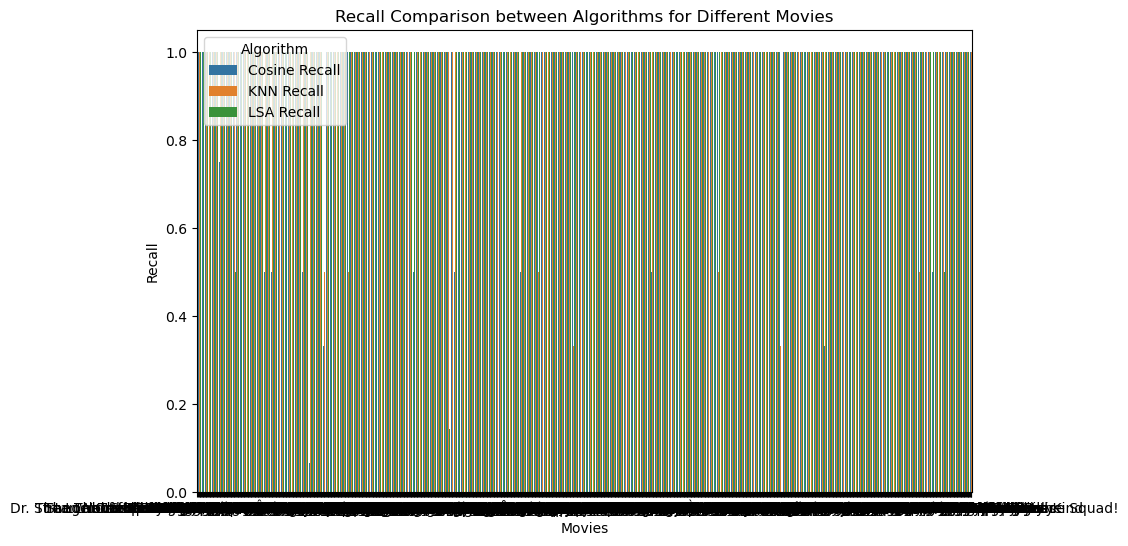

In [80]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="Recall", hue="Algorithm", data=recall_melted)

# Add title and labels
plt.title("Recall Comparison between Algorithms for Different Movies")
plt.ylabel("Recall")
plt.xlabel("Movies")

plt.show()

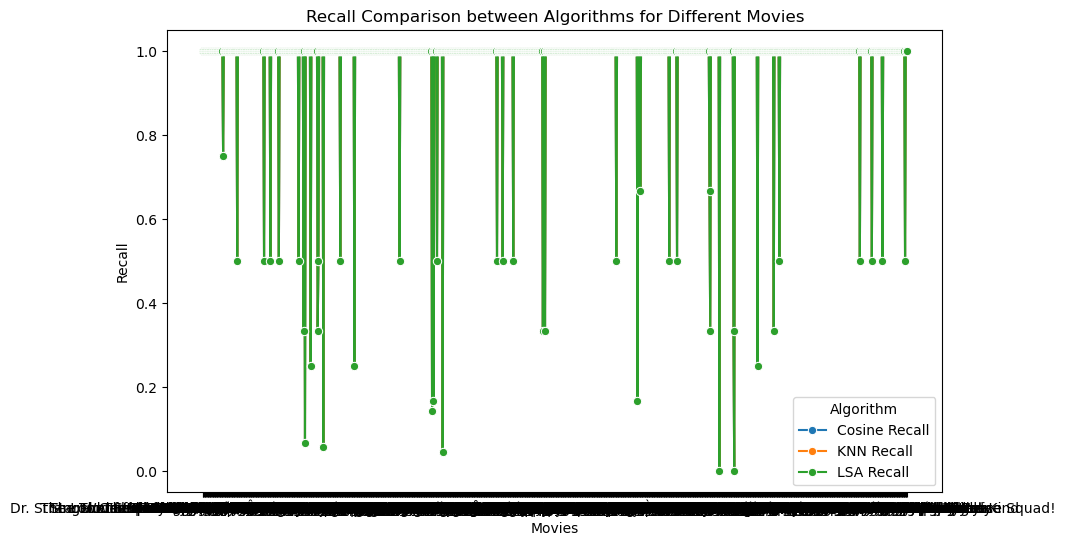

In [81]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="Recall", hue="Algorithm", data=recall_melted, marker="o")

# Add title and labels
plt.title("Recall Comparison between Algorithms for Different Movies")
plt.ylabel("Recall")
plt.xlabel("Movies")

plt.show()

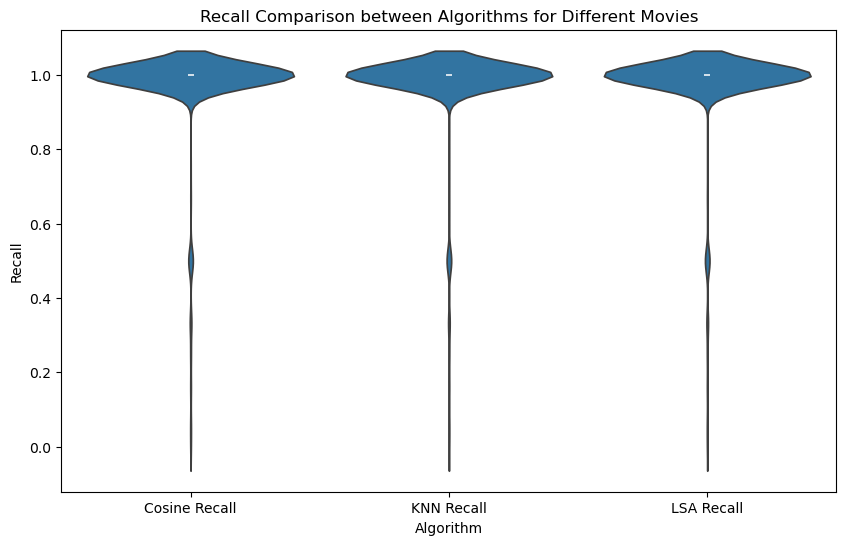

In [82]:
# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Algorithm', y='Recall', data=recall_melted)

plt.title('Recall Comparison between Algorithms for Different Movies')
plt.ylabel('Recall')
plt.xlabel('Algorithm')

plt.show()

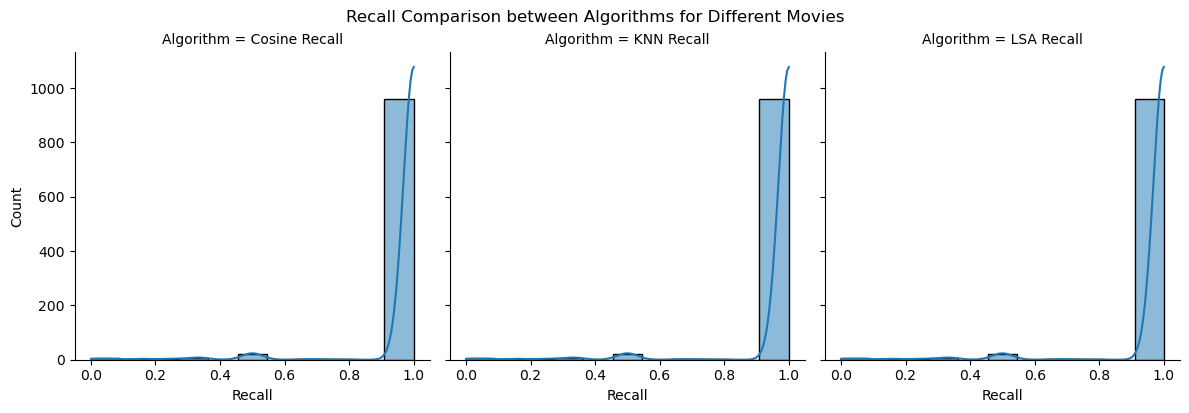

In [83]:
# FacetGrid of Histogram
g = sns.FacetGrid(recall_melted, col="Algorithm", height=4, aspect=1)
g.map(sns.histplot, "Recall", kde=True)

# Add title
plt.suptitle('Recall Comparison between Algorithms for Different Movies', y=1.02)

# Show the plot
plt.show()

c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


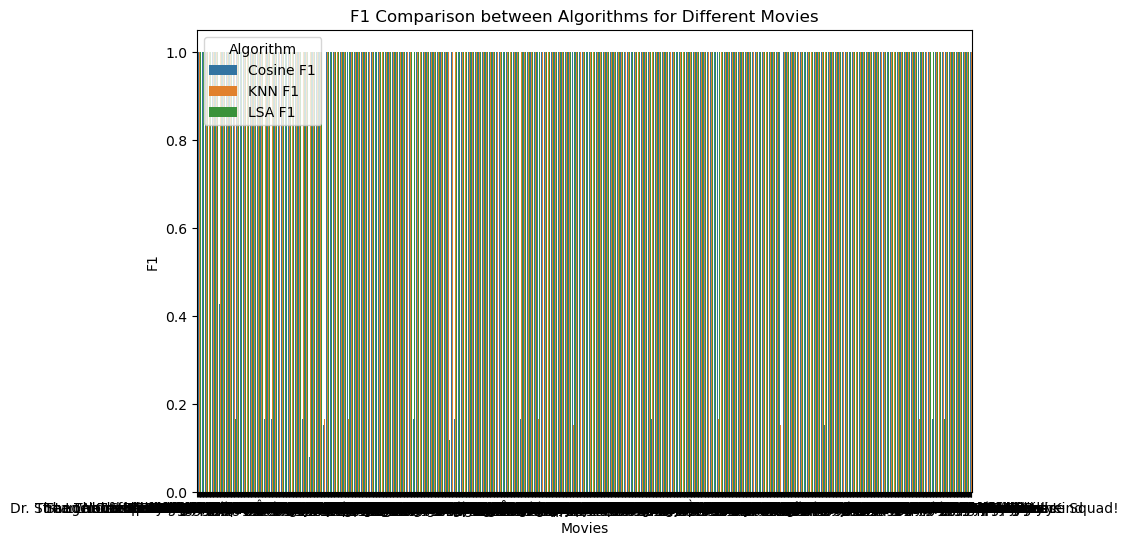

In [84]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="F1", hue="Algorithm", data=f1_melted)

# Add title and labels
plt.title("F1 Comparison between Algorithms for Different Movies")
plt.ylabel("F1")
plt.xlabel("Movies")

plt.show()

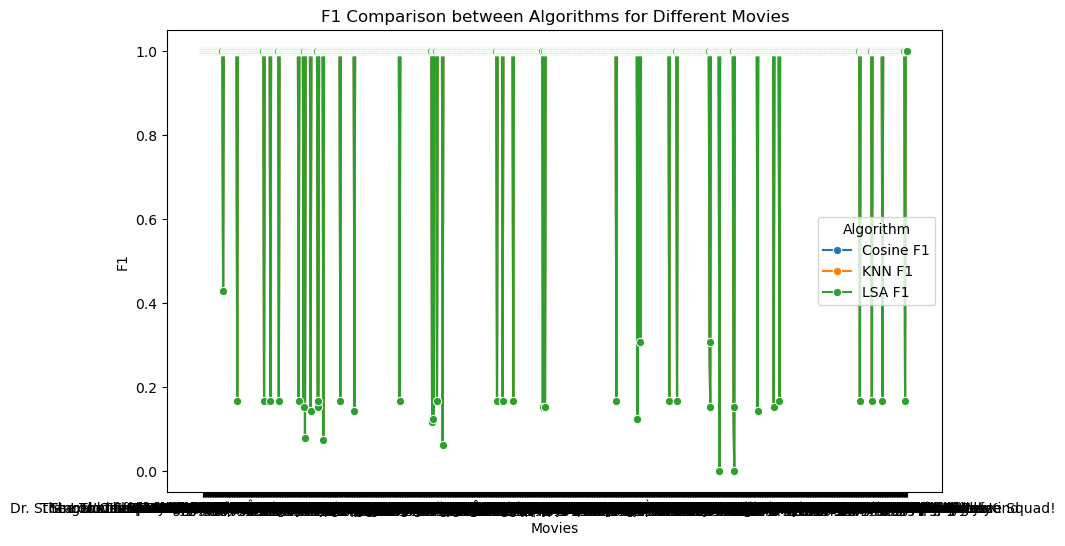

In [85]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="F1", hue="Algorithm", data=f1_melted, marker="o")

# Add title and labels
plt.title("F1 Comparison between Algorithms for Different Movies")
plt.ylabel("F1")
plt.xlabel("Movies")

plt.show()

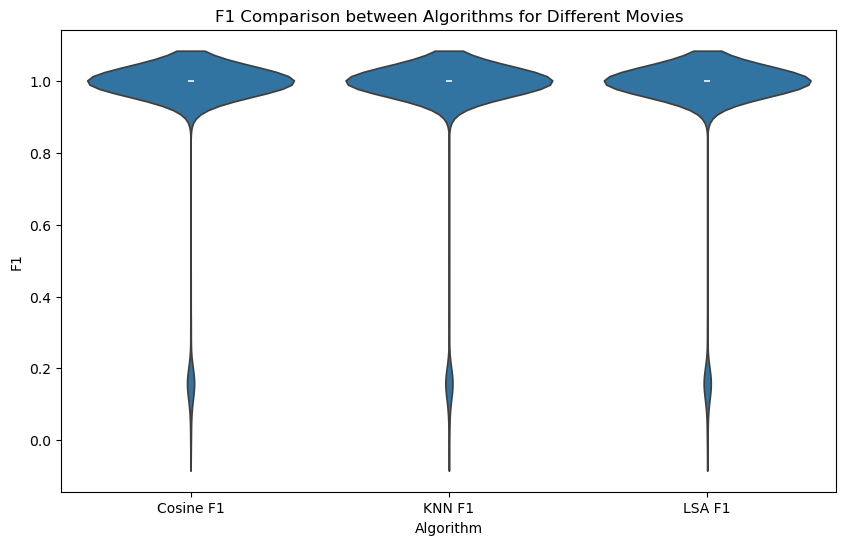

In [86]:
# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Algorithm', y='F1', data=f1_melted)

plt.title('F1 Comparison between Algorithms for Different Movies')
plt.ylabel('F1')
plt.xlabel('Algorithm')

plt.show()

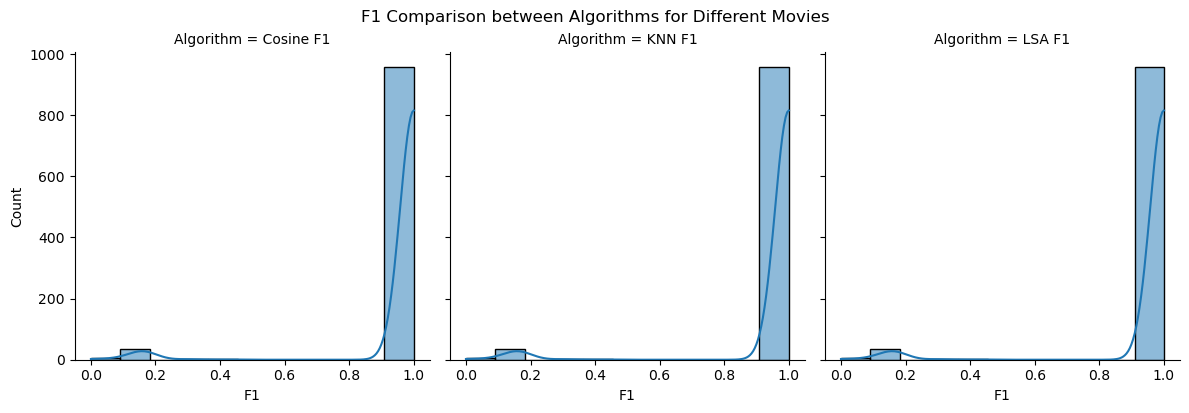

In [87]:
# FacetGrid of Histogram
g = sns.FacetGrid(f1_melted, col="Algorithm", height=4, aspect=1)
g.map(sns.histplot, "F1", kde=True)

# Add title
plt.suptitle('F1 Comparison between Algorithms for Different Movies', y=1.02)

# Show the plot
plt.show()

In [88]:
cosine_precision_df = data[["Movies", "Cosine Precision"]]
cosine_precision_df.head(3) 

,Movies,Cosine Precision
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


In [89]:
knn_precision_df = data[["Movies", "KNN Precision"]]
knn_precision_df.head(3) 

,Movies,KNN Precision
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


In [90]:
lsa_precision_df = data[["Movies", "LSA Precision"]]
lsa_precision_df.head(3) 

,Movies,LSA Precision
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


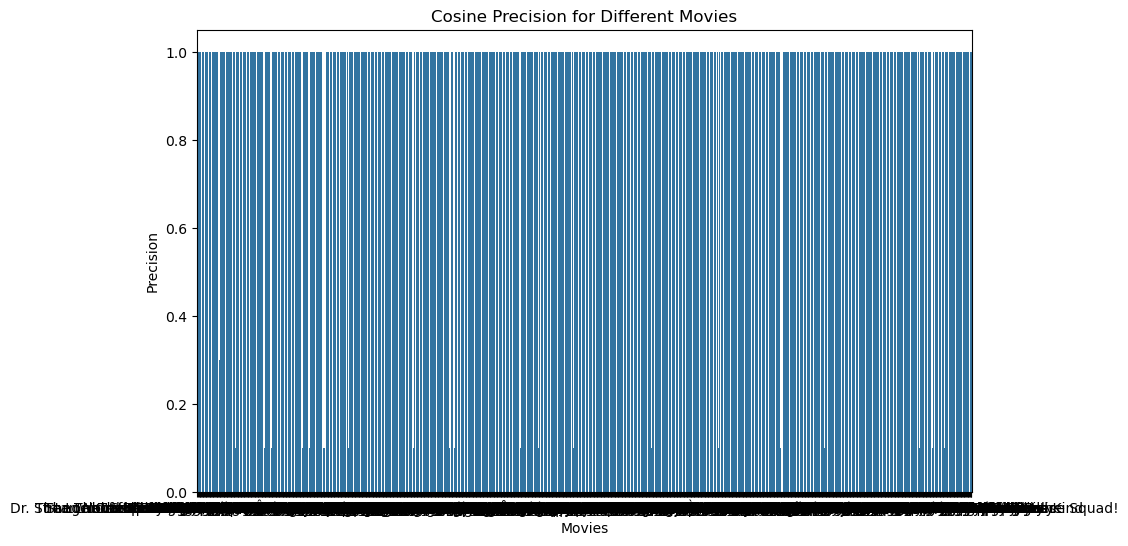

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="Cosine Precision", data=cosine_precision_df)

# Add title and labels
plt.title("Cosine Precision for Different Movies")
plt.ylabel("Precision")
plt.xlabel("Movies")

plt.show()

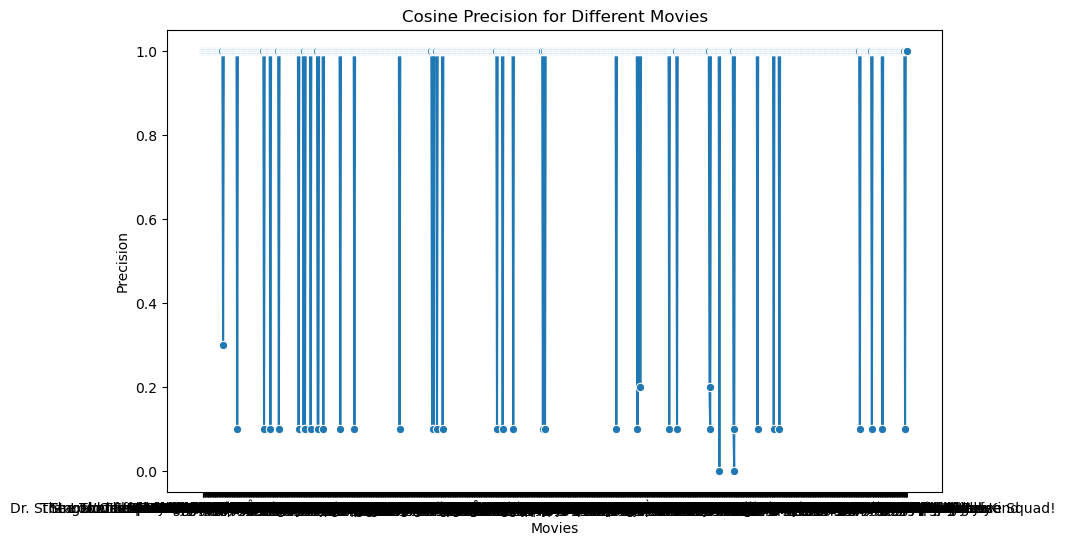

In [92]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="Cosine Precision", data=cosine_precision_df, marker="o")

# Add title and labels
plt.title("Cosine Precision for Different Movies")
plt.ylabel("Precision")
plt.xlabel("Movies")

plt.show()

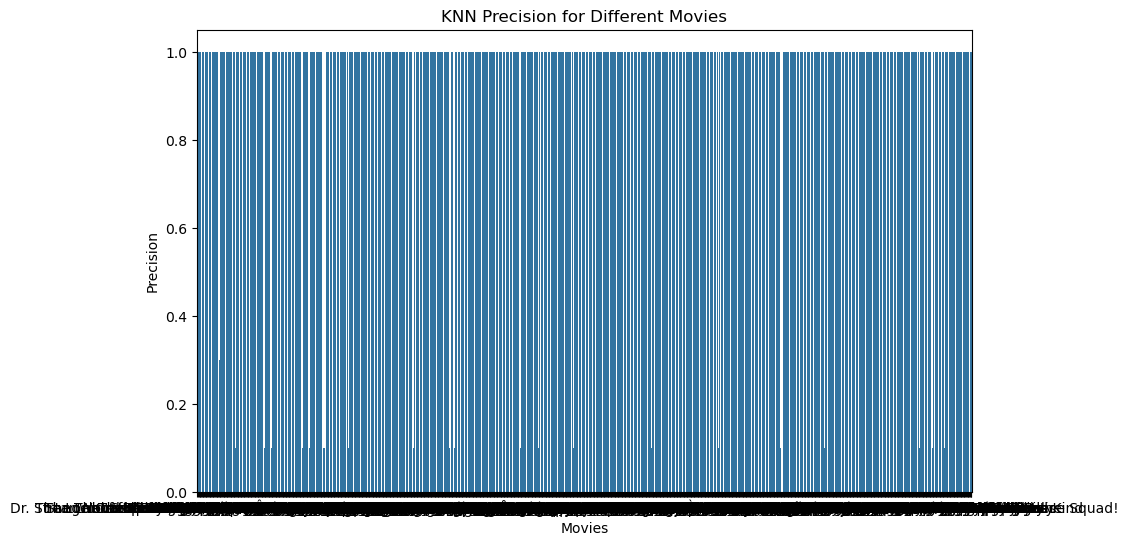

In [93]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="KNN Precision", data=knn_precision_df)

# Add title and labels
plt.title("KNN Precision for Different Movies")
plt.ylabel("Precision")
plt.xlabel("Movies")

plt.show()

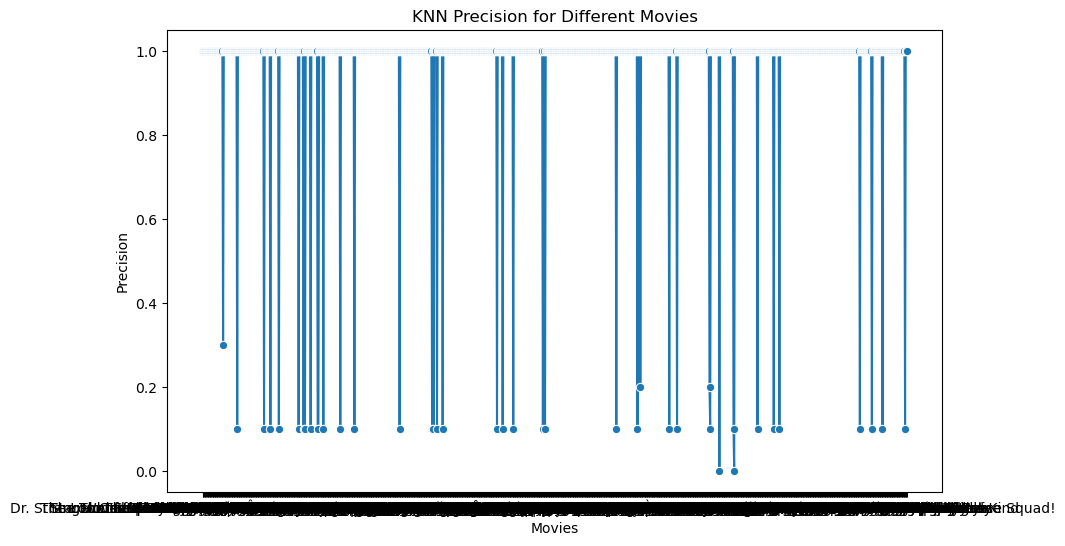

In [94]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="KNN Precision", data=knn_precision_df, marker="o")

# Add title and labels
plt.title("KNN Precision for Different Movies")
plt.ylabel("Precision")
plt.xlabel("Movies")

plt.show()

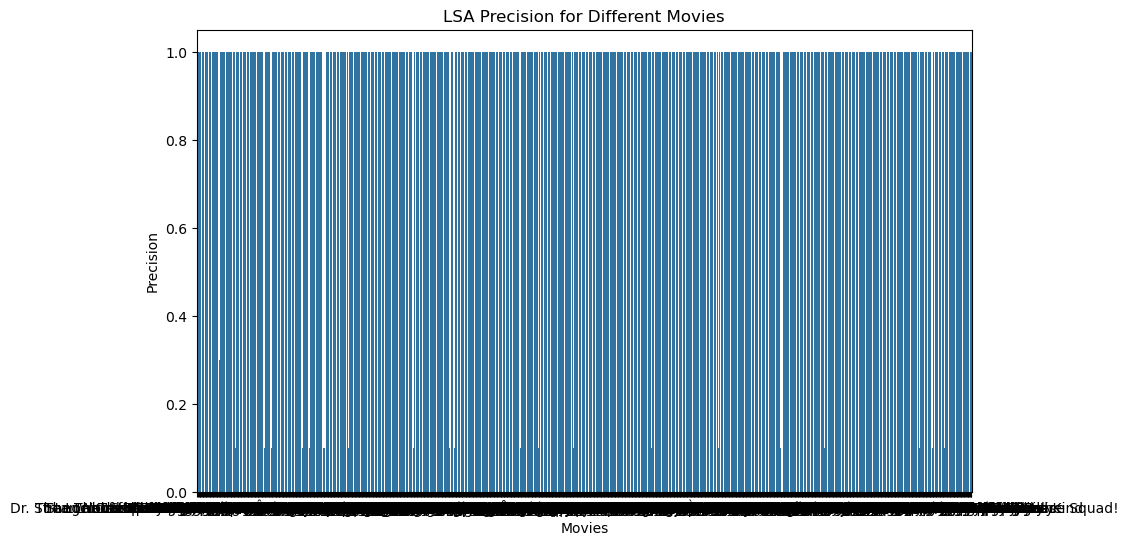

In [95]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="LSA Precision", data=lsa_precision_df)

# Add title and labels
plt.title("LSA Precision for Different Movies")
plt.ylabel("Precision")
plt.xlabel("Movies")

plt.show()

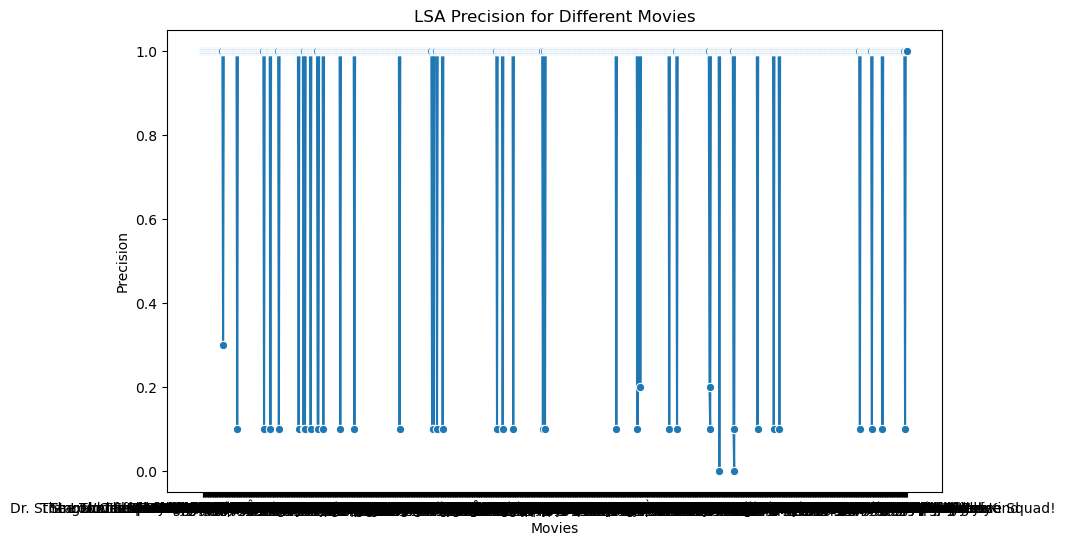

In [96]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="LSA Precision", data=lsa_precision_df, marker="o")

# Add title and labels
plt.title("LSA Precision for Different Movies")
plt.ylabel("Precision")
plt.xlabel("Movies")

plt.show()

In [97]:
cosine_recall_df = data[["Movies", "Cosine Recall"]]
cosine_recall_df.head(3) 

,Movies,Cosine Recall
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


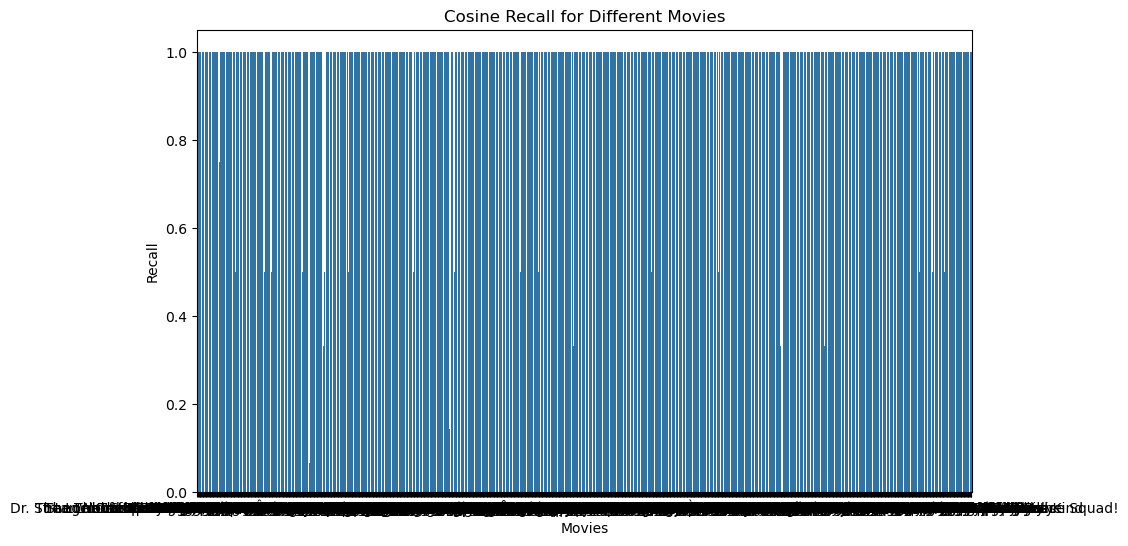

In [98]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="Cosine Recall", data=cosine_recall_df)

# Add title and labels
plt.title("Cosine Recall for Different Movies")
plt.ylabel("Recall")
plt.xlabel("Movies")

plt.show()

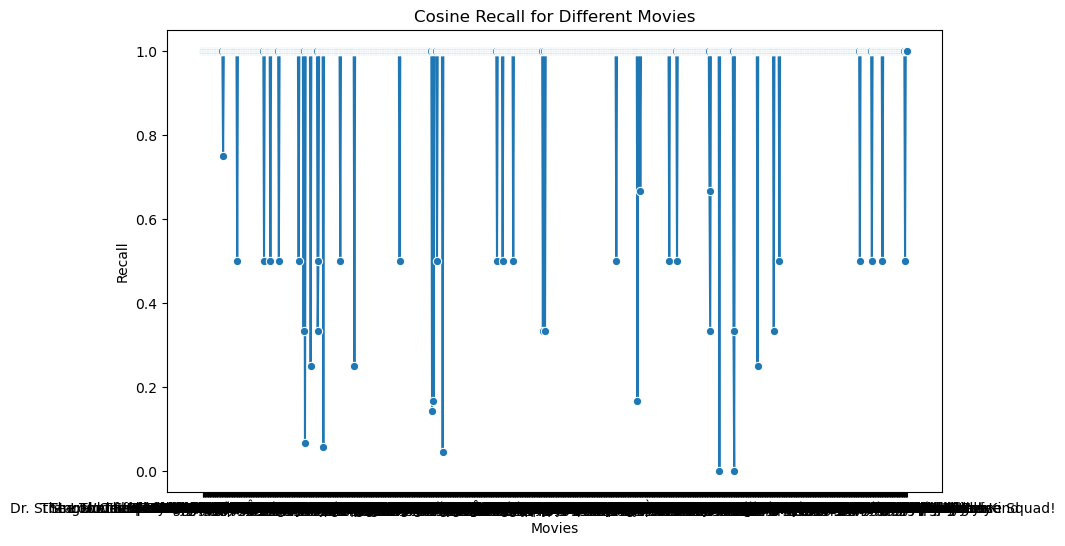

In [99]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="Cosine Recall", data=cosine_recall_df, marker="o")

# Add title and labels
plt.title("Cosine Recall for Different Movies")
plt.ylabel("Recall")
plt.xlabel("Movies")

plt.show()

In [100]:
knn_recall_df = data[["Movies", "KNN Recall"]]
knn_recall_df.head(3) 

,Movies,KNN Recall
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


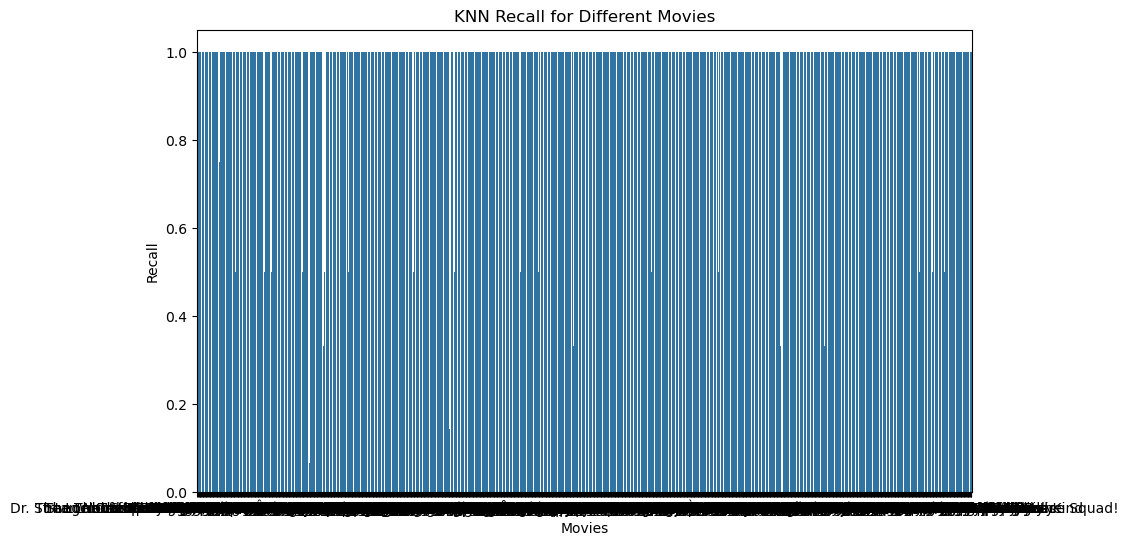

In [101]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="KNN Recall", data=knn_recall_df)

# Add title and labels
plt.title("KNN Recall for Different Movies")
plt.ylabel("Recall")
plt.xlabel("Movies")

plt.show()

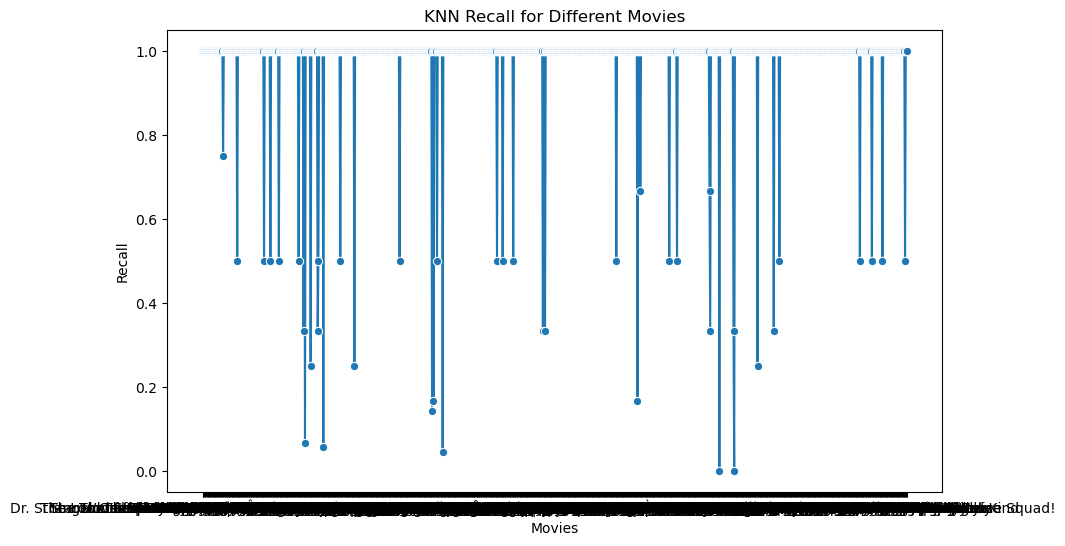

In [102]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="KNN Recall", data=knn_recall_df, marker="o")

# Add title and labels
plt.title("KNN Recall for Different Movies")
plt.ylabel("Recall")
plt.xlabel("Movies")

plt.show()

In [103]:
lsa_recall_df = data[["Movies", "LSA Recall"]]
lsa_recall_df.head(3) 

,Movies,LSA Recall
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


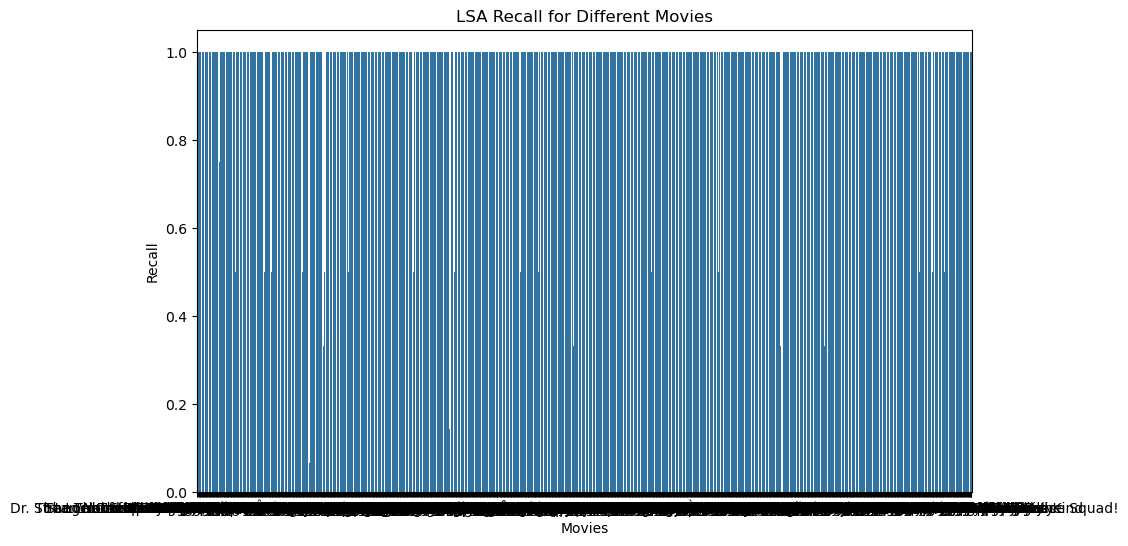

In [104]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="LSA Recall", data=lsa_recall_df)

# Add title and labels
plt.title("LSA Recall for Different Movies")
plt.ylabel("Recall")
plt.xlabel("Movies")

plt.show()

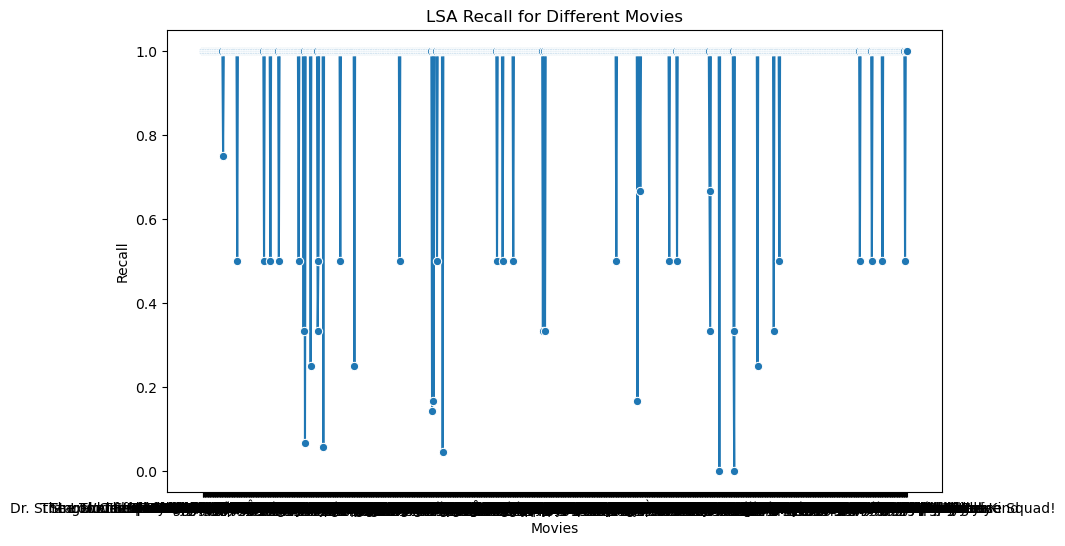

In [105]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="LSA Recall", data=lsa_recall_df, marker="o")

# Add title and labels
plt.title("LSA Recall for Different Movies")
plt.ylabel("Recall")
plt.xlabel("Movies")

plt.show()

In [106]:
cosine_f1_df = data[["Movies", "Cosine F1"]]
cosine_f1_df.head(3) 

,Movies,Cosine F1
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


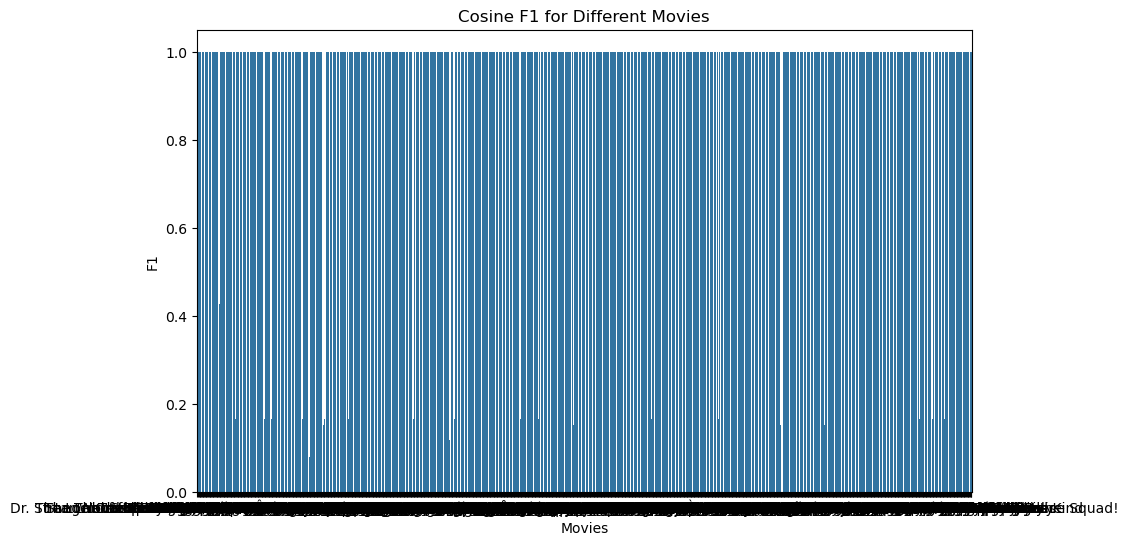

In [107]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="Cosine F1", data=cosine_f1_df)

# Add title and labels
plt.title("Cosine F1 for Different Movies")
plt.ylabel("F1")
plt.xlabel("Movies")

plt.show()

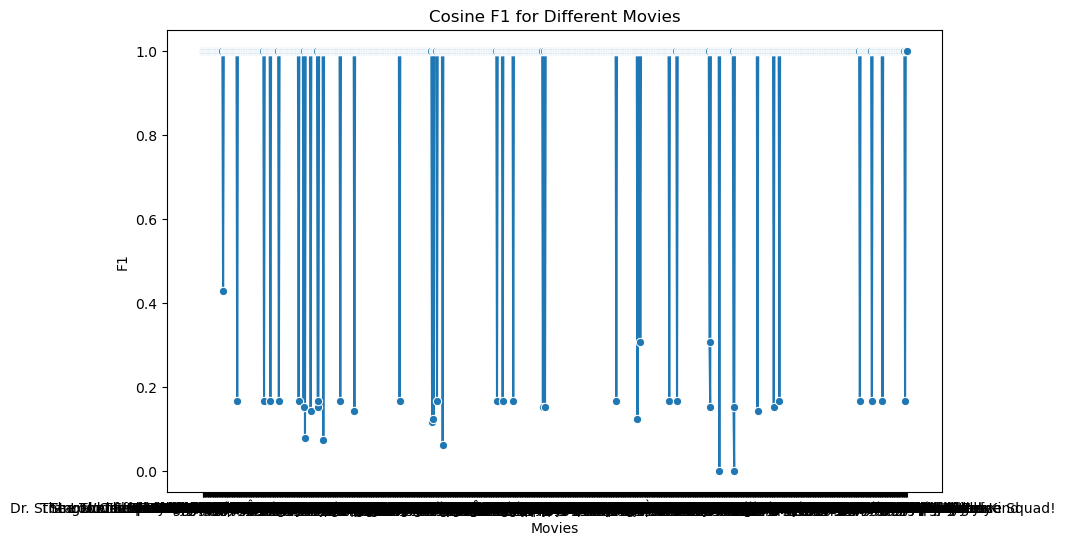

In [108]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="Cosine F1", data=cosine_f1_df, marker="o")

# Add title and labels
plt.title("Cosine F1 for Different Movies")
plt.ylabel("F1")
plt.xlabel("Movies")

plt.show()

In [109]:
knn_f1_df = data[["Movies", "KNN F1"]]
knn_f1_df.head(3) 

,Movies,KNN F1
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


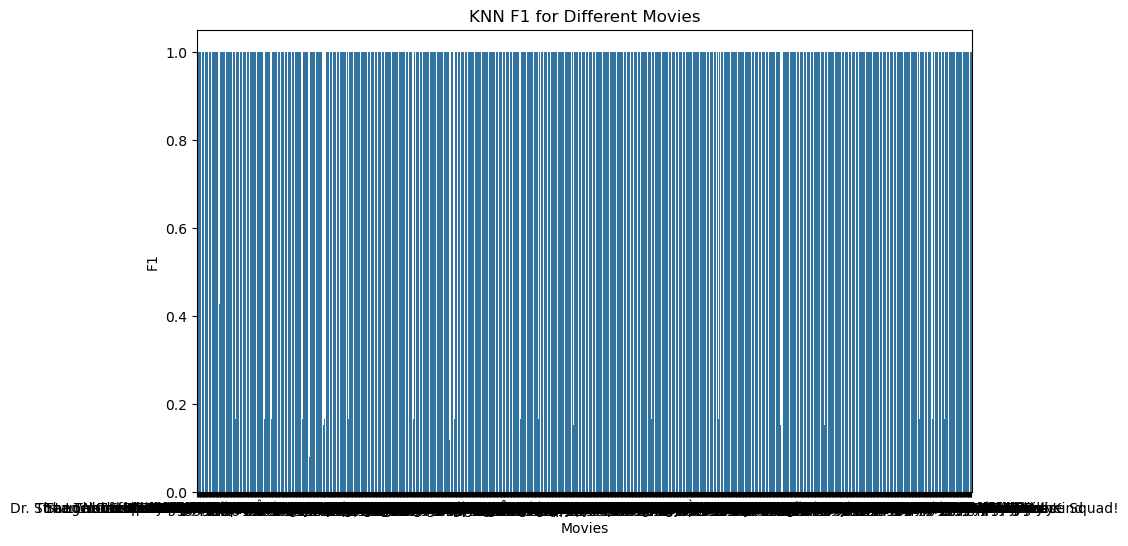

In [110]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="KNN F1", data=knn_f1_df)

# Add title and labels
plt.title("KNN F1 for Different Movies")
plt.ylabel("F1")
plt.xlabel("Movies")

plt.show()

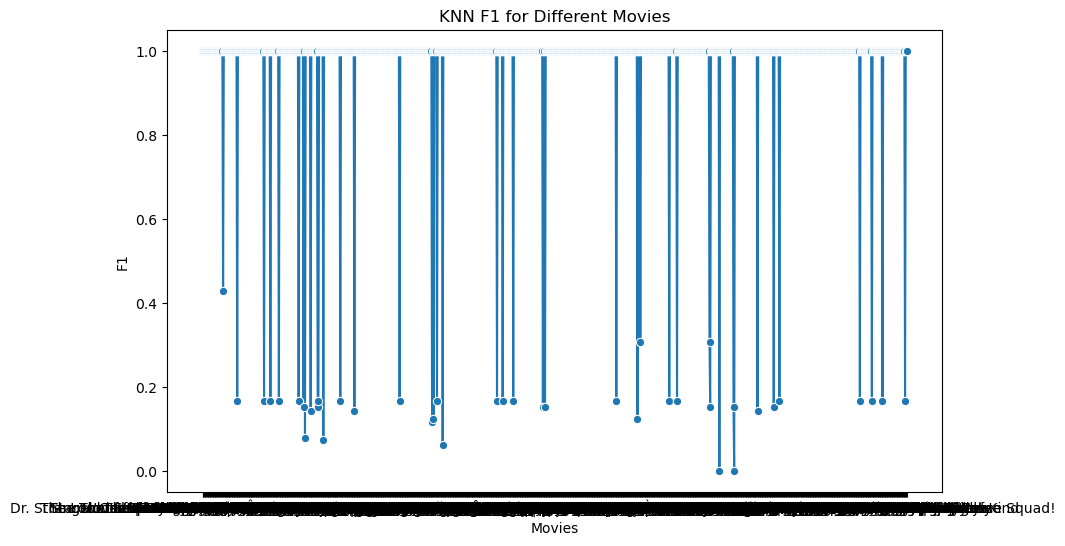

In [111]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="KNN F1", data=knn_f1_df, marker="o")

# Add title and labels
plt.title("KNN F1 for Different Movies")
plt.ylabel("F1")
plt.xlabel("Movies")

plt.show()

In [112]:
lsa_f1_df = data[["Movies", "LSA F1"]]
lsa_f1_df.head(3) 

,Movies,LSA F1
0,The Shawshank Redemption,1.0
1,The Godfather,1.0
2,The Dark Knight,1.0


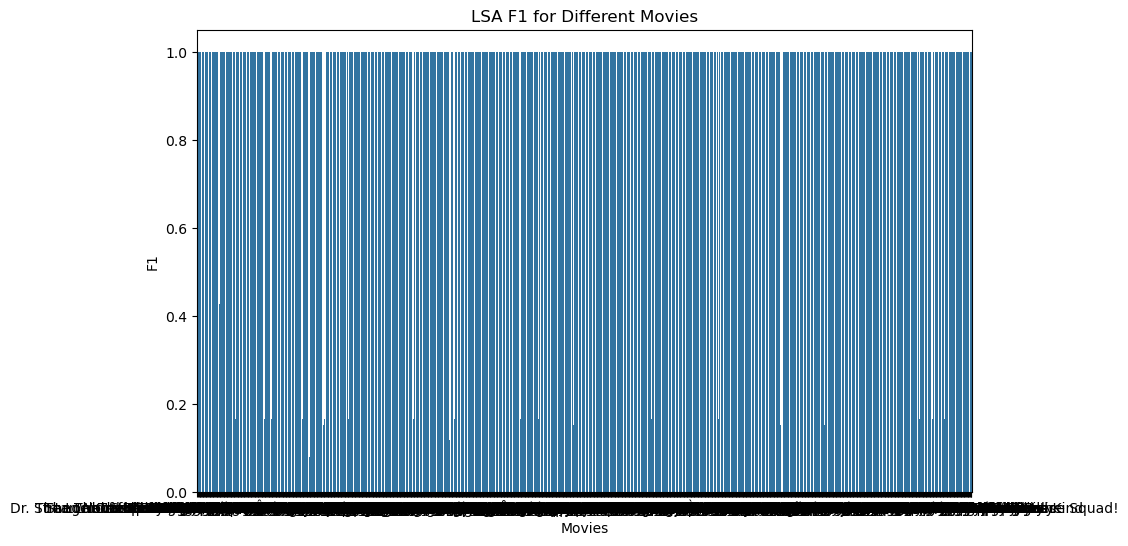

In [113]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="LSA F1", data=lsa_f1_df)

# Add title and labels
plt.title("LSA F1 for Different Movies")
plt.ylabel("F1")
plt.xlabel("Movies")

plt.show()

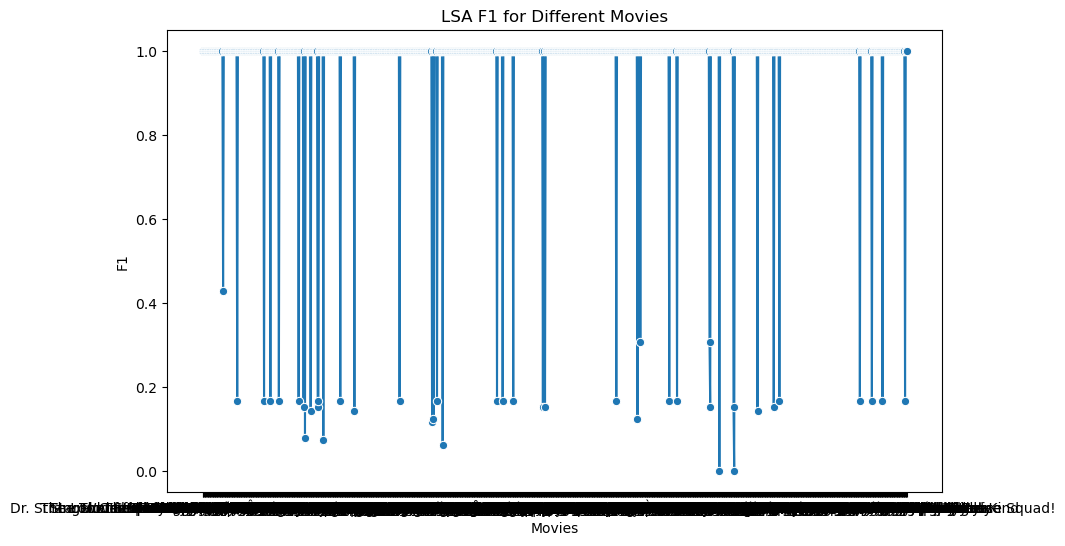

In [114]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="LSA F1", data=lsa_f1_df, marker="o")

# Add title and labels
plt.title("LSA F1 for Different Movies")
plt.ylabel("F1")
plt.xlabel("Movies")

plt.show()